In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, ConcatDataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datetime import datetime
from torchvision.utils import make_grid
from tqdm import tqdm
import os
import cv2
import random
import CustomClassifier

In [2]:
def binary_classification_loader(images_0, images_1):
    # 클래스 라벨링: 0에 해당하는 이미지는 라벨 0, 1에 해당하는 이미지는 라벨 1로 할당
    labeled_data = []
    for img in images_0:
        labeled_data.append((img, 0))
    for img in images_1:
        labeled_data.append((img, 1))
    
    # 이미지와 라벨을 따로 추출하여 반환
    images, labels = zip(*labeled_data)
    return np.array(images), np.array(labels)

In [3]:
# 이미지 데이터를 로드하는 코드
images_0 = np.load('NOTWALL_PATH') #class 0 = not wall, 1 = wall
images_1 = np.load('WALL_PATH')

# 데이터 로더 호출
train_images, train_labels = binary_classification_loader(images_0, images_1)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# params 딕셔너리에서 brightness_factor를 가져오기
params = {
    "brightness_factor": 0.5  # 예시값, 실제로 사용할 값을 설정해야 합니다.
}

# 밝기 조절을 위한 factor 설정
brightness_factor = 1 + (torch.rand(1).item() * 2 - 1) * params["brightness_factor"]


In [6]:
# 데이터 증강을 위한 변환 정의
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.3),
    transforms.Resize((256,256)),
    transforms.ColorJitter(brightness=brightness_factor)  # 이미지 밝기 조절 변환 추가
])


# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, select_label=None, limit=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.select_label = select_label
        self.limit = limit

    def __len__(self):
        if self.limit is not None:
            return self.limit
            
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.select_label is not None and label != self.select_label:
            return self.__getitem__(idx + 1)

        if self.transform:
            image = self.transform(TF.to_pil_image(image))
            image = TF.to_tensor(image)
        else:
            image = TF.to_tensor(image)

        return image, label

# original_dataset = CustomDataset(train_images, train_labels)
augmented_dataset = CustomDataset(train_images, train_labels, transform)

dataset = ConcatDataset([augmented_dataset])

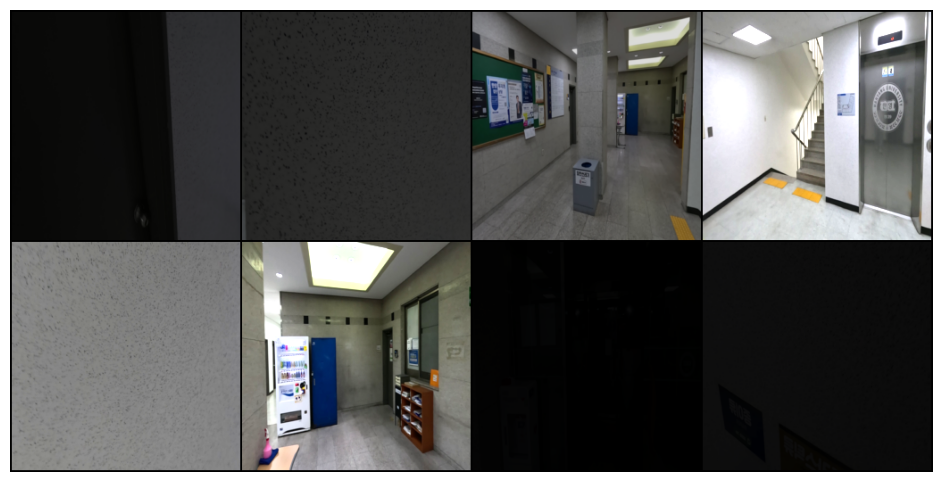

In [7]:
# 데이터셋에서 이미지 가져오기
sample_loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=8, shuffle=True)

# 이미지 시각화
for images, labels in sample_loader:
    plt.figure(figsize=(12, 6))
    grid_imgs = make_grid(images, nrow=4)
    plt.imshow(grid_imgs.permute(1, 2, 0))  # 이미지 차원 변환 (C, H, W) -> (H, W, C)
    plt.axis('off')  # 축 제거
    plt.show()
    break  # 첫 번째 배치만 시각화

In [8]:
# 데이터를 train과 validation 세트로 나누기
train_size = int(0.7 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 데이터로더 설정
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [9]:
model = CustomClassifier()
model.to(device)

CustomClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.15, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=460800, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
# Hyperparameters
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
# Define training and validation functions
def train(model, train_loader, epoch):
    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"epoch {epoch}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view_as(outputs).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(train_loader)

In [13]:
def validate(model, valid_loader):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs).float())
            valid_loss += loss.item()
            predicted = (outputs > 0.5).squeeze()
            total += labels.size(0)
            correct += (predicted == labels.byte()).sum().item()

    accuracy = 100 * correct / total
    return valid_loss / len(valid_loader), accuracy

In [14]:
train_losses = []
valid_losses = []

epochs = 20

for epoch in range(epochs):
    
    train_loss = train(model, train_loader, epoch)
    valid_loss, valid_accuracy = validate(model, valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Training Loss: {train_loss:.4f}")
    print(f"  Validation Loss: {valid_loss:.4f}")
    print(f"  Validation Accuracy: {valid_accuracy:.2f}%")

now = datetime.now()

torch.save(model.state_dict(), f'{now.strftime("%Y-%m-%d_%H:%M:%S")}.pth')


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.92it/s]


Epoch 1/20:
  Training Loss: 0.6401
  Validation Loss: 0.3930
  Validation Accuracy: 82.21%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.97it/s]


Epoch 2/20:
  Training Loss: 0.2353
  Validation Loss: 0.1386
  Validation Accuracy: 94.35%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.91it/s]


Epoch 3/20:
  Training Loss: 0.0725
  Validation Loss: 0.0378
  Validation Accuracy: 98.70%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.89it/s]


Epoch 4/20:
  Training Loss: 0.0690
  Validation Loss: 0.0358
  Validation Accuracy: 98.41%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 5/20:
  Training Loss: 0.0317
  Validation Loss: 0.0224
  Validation Accuracy: 99.31%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 6/20:
  Training Loss: 0.0236
  Validation Loss: 0.0201
  Validation Accuracy: 99.07%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 7/20:
  Training Loss: 0.0315
  Validation Loss: 0.0263
  Validation Accuracy: 99.19%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 8/20:
  Training Loss: 0.0181
  Validation Loss: 0.0095
  Validation Accuracy: 99.60%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.89it/s]


Epoch 9/20:
  Training Loss: 0.0112
  Validation Loss: 0.0093
  Validation Accuracy: 99.53%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 10/20:
  Training Loss: 0.0090
  Validation Loss: 0.0078
  Validation Accuracy: 99.67%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 11/20:
  Training Loss: 0.0099
  Validation Loss: 0.0097
  Validation Accuracy: 99.57%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 12/20:
  Training Loss: 0.0225
  Validation Loss: 0.0130
  Validation Accuracy: 99.48%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 13/20:
  Training Loss: 0.0251
  Validation Loss: 0.0294
  Validation Accuracy: 98.84%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 14/20:
  Training Loss: 0.0139
  Validation Loss: 0.0101
  Validation Accuracy: 99.53%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 15/20:
  Training Loss: 0.0101
  Validation Loss: 0.0062
  Validation Accuracy: 99.74%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.85it/s]


Epoch 16/20:
  Training Loss: 0.0087
  Validation Loss: 0.0091
  Validation Accuracy: 99.72%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 17/20:
  Training Loss: 0.0071
  Validation Loss: 0.0046
  Validation Accuracy: 99.81%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 18/20:
  Training Loss: 0.0076
  Validation Loss: 0.0066
  Validation Accuracy: 99.69%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.86it/s]


Epoch 19/20:
  Training Loss: 0.0059
  Validation Loss: 0.0061
  Validation Accuracy: 99.72%


100%|██████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.88it/s]

Epoch 20/20:
  Training Loss: 0.0085
  Validation Loss: 0.0061
  Validation Accuracy: 99.79%
